In [60]:
import torch
import torch.nn as nn
import numpy as np

INPUT_DIM = 60
HOLDOUT = 200

LOG = False
def log(*args):
    global LOG
    if LOG:
        print(*args)

class AttentionModel(nn.Module):
    def __init__(self,  seq_dim=1, attention_dim=32):
        super(AttentionModel, self).__init__()
       
        self.seq_dim = seq_dim
        self.attention_dim = attention_dim
        
        #print(f" Seq dim: {self.seq_dim}, Attention dim: {self.attention_dim}")
        self.wk = nn.Linear( self.seq_dim, self.attention_dim, bias=False)
        self.wv = nn.Linear( self.seq_dim, self.attention_dim, bias=False)
        self.wq = nn.Linear( self.seq_dim, self.attention_dim,  bias=False)


    def forward(self, input):
        
        k = self.wk(input)
        v = self.wv(input)
        q = self.wq(input)
        #print(f"Input shape: {input.shape}, K shape: {k.shape}, V shape: {v.shape}, Q shape: {q.shape}")
        score = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.attention_dim)
        
        weights = torch.softmax(score, dim=1)
        #print(f"Score shape: {score.shape}, Weights: {weights.shape}")
        attention = torch.matmul(weights, v)
        #print(f"Attention shape: {attention.shape}")

        return attention, weights
    
test = torch.tensor([[1,2,3],[4,5,6],[4,3,2],[4,5,5],[7,8, 3]], dtype=torch.float32)


att = AttentionModel( seq_dim=3)


print(test, test.shape)
#test = test.transpose(0,1)
o = att.forward(test)
print("Att",o[0].squeeze(0))
print("Wt",o[1].squeeze(0))

        


class DeepNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, attention_dim = 120):
        super(DeepNNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.attenton_dim = attention_dim

        
        self.att = AttentionModel( seq_dim=input_dim, attention_dim=attention_dim)
   #

        self.predictor = nn.Sequential(
            nn.Linear(attention_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Sigmoid(),
            nn.Linear(hidden_dim, 1)


        ) 



    def forward(self, x):

        log(f"Input shape: {x.shape}")
        #x = x.transpose(0,1)  # Change shape from (batch_size, seq_len, input_dim) to (batch_size, input_dim, seq_len)
        #log(f"Input shape: {x.shape}")
        # lstm_out, _ = self.lstm(x)
        # log(f"LSTM output shape: {lstm_out.shape}")
        # Change shape from (batch_size, seq_len, input_dim) to (batch_size, input_dim, seq_len)
        a,_ = self.att(x)
        log(f"Attention output shape: {a.shape}")

        # alpha = torch.softmax(e, dim=1).unsqueeze(-1)
        # log(f"Attention scores shape: {alpha.shape}")
        # context = torch.sum(alpha * x, dim=1)
        # log(f"Context vector shape: {context.shape}")
        output = self.predictor(torch.add(x,a)  )
        #output = self.predictor(x)

        #self.attn_alpha.append(alpha.squeeze(-1).detach().numpy())

        return output#, alpha.squeeze(-1)

    def train_model(self, data, device='cpu', num_epochs=50, patience=5, learning_rate=0.01):
        self.to(device)
        self.train()
        
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        criterion = nn.L1Loss() # Using L1 loss for regression tasks

        best_loss = float('inf')
        epochs_without_improvement = 0

        for epoch in range(num_epochs):
            total_loss = 0.0
            train_losses = []

            for inputs, targets in data:
                
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                train_losses.append(loss.item())

            avg_loss = total_loss / len(data)


            if avg_loss < best_loss:
                best_loss = avg_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break

        torch.save(self.state_dict(), 'best_model.pth')
        print("Training complete.")

    @classmethod
    def load_model(cls, checkpoint_path, device='cpu', **kwargs):
        """
        Loads a trained AttentionModel.
        Args:
            checkpoint_path (str): Path to saved .pth file.
            device (str): 'cpu' or 'cuda'.
            kwargs: Keyword arguments for the model constructor (e.g., input_dim, hidden_dim)
        Returns:
            AttentionModel instance with weights loaded.
        """
        model = cls(**kwargs)
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        model.to(device)
        model.eval()
        return model

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [4., 3., 2.],
        [4., 5., 5.],
        [7., 8., 3.]]) torch.Size([5, 3])
Att tensor([[ 0.7773, -1.3568, -1.8565,  1.6219,  0.8307,  0.1202,  0.5037,  1.1844,
         -0.2513, -1.4876, -3.0575,  0.5426, -3.3790,  0.5006,  1.3844,  0.0690,
         -1.2859, -1.9231,  1.0973, -1.0720,  0.9584,  0.2322,  0.0645,  0.6902,
          2.6229, -1.1080,  3.2433,  2.3345,  3.8182, -1.4525, -3.0040, -1.4183],
        [ 0.8680, -1.4711, -1.9990,  1.7670,  0.9241,  0.1823,  0.4872,  1.3003,
         -0.2326, -1.5627, -3.2298,  0.6104, -3.5586,  0.4982,  1.4143, -0.0290,
         -1.3359, -2.1041,  1.1803, -1.1358,  1.0202,  0.2213,  0.2034,  0.6677,
          2.8221, -1.1591,  3.4714,  2.4750,  4.0532, -1.4420, -3.2020, -1.5455],
        [ 1.0325, -1.8672, -2.7154,  2.2267,  1.1050,  0.0711,  0.9634,  1.4971,
         -0.4267, -2.2563, -4.5730,  0.7413, -5.0797,  0.9043,  2.2416,  0.4280,
         -2.0465, -2.7231,  1.5722, -1.6491,  1.3613, 

Downloading:  XRP-USD
2774


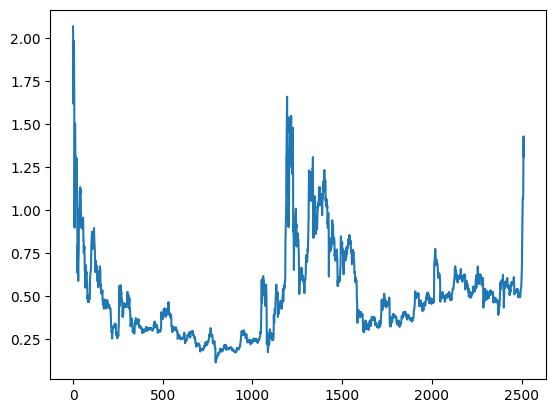

torch.Size([32, 60])


In [61]:
from matplotlib import pyplot as plt
import stock_libs
import stock_libs.yhf_lib



#X = torch.tensor([(np.sin(np.pi*i/24)+torch.rand(1,1)+(0.01*i)).tolist() for i in range(1000)])
#X = torch.tensor([(np.sqrt(0.01*i)+np.sin(i/250)*torch.ones(1,1)).tolist() for i in range(1000)])

def build_real_data_set(symbol):
    real_data = stock_libs.yhf_lib.download_code(symbol, download_data=True, force_download=True, path="..")
    print(len(real_data))
    #real_data =  torch.tensor([(np.sqrt(0.01*i)+np.sin(i/250)*torch.ones(1,1)).tolist() for i in range(1000)])
    #X = real_data
    X = torch.tensor([(real_data["Low"].iloc[i]*torch.ones(1,1)).tolist() for i in range(0,len(real_data))])
    Xtrunc = X[:len(real_data)-HOLDOUT]

    return X, Xtrunc 

Xfull, X = build_real_data_set("XRP-USD")


plt.plot(X[INPUT_DIM:].squeeze(-1).detach().numpy(), label='Actual')
plt.show()
# Y = torch.tensor([0 if sum(x)> 0 else 1  for x in X])
# print(len(X), len(Y))

def build_training_data(X, batches = 100, length=30, batch_size=32):
    training_data = []
    if len(X) < length:
        raise ValueError("Input data length must be at least equal to the specified length.")
    
    for i in range(batches):
        batchX = []
        batchY=[]
        for _ in range(batch_size):
            start = np.random.randint(0, len(X) - length)
            end = start + length
            batchX.append(X[start:end])
            batchY.append(X[end])
        training_data.append((torch.stack(batchX).squeeze(-1).squeeze(-1), torch.tensor(batchY)))

    return training_data



data = build_training_data(X,batches=100, length=INPUT_DIM, batch_size=32)
 
print(data[0][0].shape)


In [ ]:
model = DeepNNModel(input_dim=INPUT_DIM, hidden_dim=256, attention_dim=INPUT_DIM)

model.train_model(data=data, device='cpu', num_epochs=500, patience=100, learning_rate=0.0001)
#


yhat = model(data[0][0].unsqueeze(0).float())


# from torchviz import make_dot
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("model_architecture", format="png")


Epoch 1/500, Loss: 0.2277
Epoch 2/500, Loss: 0.1895
Epoch 3/500, Loss: 0.1851
Epoch 4/500, Loss: 0.1433
Epoch 5/500, Loss: 0.1020
Epoch 6/500, Loss: 0.0919
Epoch 7/500, Loss: 0.0869
Epoch 8/500, Loss: 0.0832
Epoch 9/500, Loss: 0.0792
Epoch 10/500, Loss: 0.0767
Epoch 11/500, Loss: 0.0752
Epoch 12/500, Loss: 0.0738
Epoch 13/500, Loss: 0.0726
Epoch 14/500, Loss: 0.0708
Epoch 15/500, Loss: 0.0696
Epoch 16/500, Loss: 0.0688
Epoch 17/500, Loss: 0.0684
Epoch 18/500, Loss: 0.0677
Epoch 19/500, Loss: 0.0666
Epoch 20/500, Loss: 0.0661
Epoch 21/500, Loss: 0.0649
Epoch 22/500, Loss: 0.0641
Epoch 23/500, Loss: 0.0634
Epoch 24/500, Loss: 0.0628
Epoch 25/500, Loss: 0.0621
Epoch 26/500, Loss: 0.0611
Epoch 27/500, Loss: 0.0606
Epoch 28/500, Loss: 0.0602
Epoch 29/500, Loss: 0.0599
Epoch 30/500, Loss: 0.0588
Epoch 31/500, Loss: 0.0581
Epoch 32/500, Loss: 0.0578
Epoch 33/500, Loss: 0.0574
Epoch 34/500, Loss: 0.0567
Epoch 35/500, Loss: 0.0563
Epoch 36/500, Loss: 0.0556
Epoch 37/500, Loss: 0.0552
Epoch 38/5

torch.Size([200]) 2773 -700
torch.Size([2528])


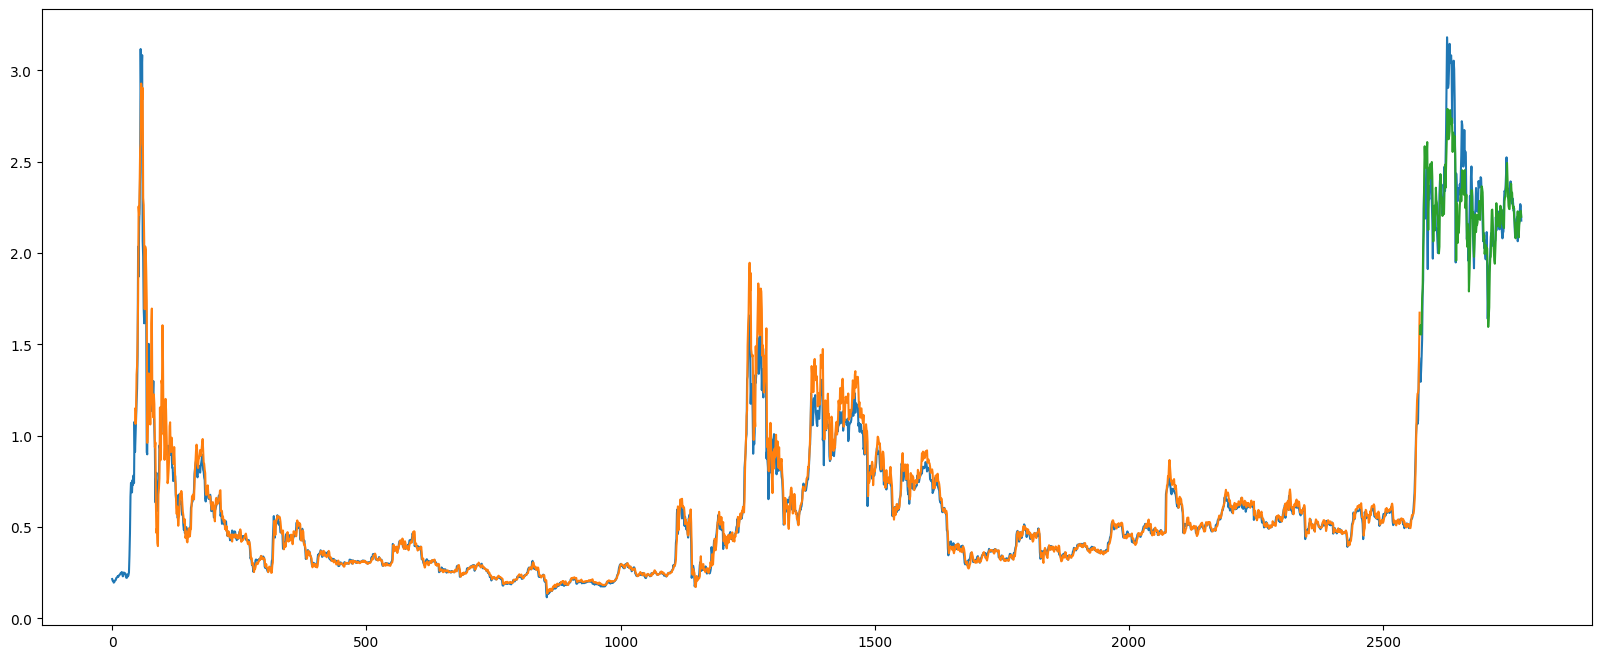

In [ ]:
PRE_LOAD = 500
x_hat = []

l = len(Xfull) - HOLDOUT
##
for idx in range(0,HOLDOUT):
    x = Xfull[l+idx-INPUT_DIM:l+idx]
    #print(len(x), idx, "ST_", l+idx-INPUT_DIM, "END_", l+idx, ">>",(l+idx-INPUT_DIM-(l+idx)), "BASE_C", l , "LEN_C",len(Xfull))
    yhat = model(x.squeeze(-1).transpose(0,1))
    x_hat.append(yhat[0].detach().numpy())

##
stable = []
for idx in range(INPUT_DIM, len(Xfull)-HOLDOUT):
    x = X[idx-INPUT_DIM:idx]
    #print(x.shape)
    yhat = model(x.squeeze(-1).transpose(0,1))
    stable.append(yhat[0].detach().numpy())

x_hat = torch.tensor(x_hat).squeeze(-1)
print(x_hat.shape, len(Xfull), -HOLDOUT-PRE_LOAD)
stable = torch.tensor(stable).squeeze(-1)
print(stable.shape)

ax, fig = plt.subplots(1, 1, figsize=(20, 8))
#fig[0].plot(model.attn_alpha[0])

fig.plot(Xfull.squeeze(-1).detach().numpy(), label='Actual')
fig.plot(list([i for i in range(INPUT_DIM,len(Xfull)-HOLDOUT)]), stable.detach().numpy(), label='Stable')
fig.plot(list([i for i in range(len(Xfull)-(HOLDOUT),len(Xfull))]), x_hat.detach().numpy(), label='Forecast')

plt.show()



